In [1002]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MinMaxScaler

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

import umap

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout, LSTM, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
import time

from scipy import fftpack
from sklearn.metrics import mean_squared_error

In [6]:
df = pd.read_csv('capstone_dataset.csv')
subject_iden_col=['iso']
time_iden_cols=['year']

target_cols=['WB_ny_gdp_mktp_cd', 'WB_ny_gdp_defl_kd_zg']
target_subjects=['USA',' WLD']

target_periods=5

C:\Users\xps-haydo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5,6,1594,1595,1596,1597,1598,3182,3183,3184,3185,3186,3187,3220,3229,3278,3279,3280,3281,3292,3318,3319,3320,3321,3322,3323,3354,3355,3357,3450) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
df.head()

,iso,countrycode,countryname,year,regionname,adminregion,adminregionname,incomelevel,incomelevelname,lendingtype,...,QG_wdi_unempfilo,QG_wdi_unempilo,QG_wdi_unempmilo,QG_wdi_unempyfilo,QG_wdi_unempyilo,QG_wdi_unempymilo,QG_wdi_wip,QG_who_sanittot,QG_whr_hap,QG_wr_regtype
0,ABW,ABW,Aruba,1961,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABW,ABW,Aruba,1962,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABW,ABW,Aruba,1963,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABW,ABW,Aruba,1964,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABW,ABW,Aruba,1965,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15312 entries, 0 to 15311
Columns: 3451 entries, iso to QG_wr_regtype
dtypes: float64(3398), int64(1), object(52)
memory usage: 403.2+ MB


In [9]:
data_info = pd.read_csv('features_dictionary.csv')

In [10]:
def feat_info(cols: list) :
    return data_info[data_info['Identifier'].isin(cols)]

In [11]:
feat_info(target_cols)

,Identifier,Description,Source,Publisher,Year,Topic
298,WB_ny_gdp_defl_kd_zg,"Inflation, GDP deflator (annual %)",World Development Indicators,The World Bank Group,2018,Economic Growth
306,WB_ny_gdp_mktp_cd,GDP (current US$),World Development Indicators,The World Bank Group,2018,Economic Growth


In [12]:
df[subject_iden_col+time_iden_cols+target_cols].tail()

,iso,year,WB_ny_gdp_mktp_cd,WB_ny_gdp_defl_kd_zg
15307,ZWE,2014,1.949552e+10,-0.252141
15308,ZWE,2015,1.996312e+10,0.607814
15309,ZWE,2016,2.054868e+10,2.160993
15310,ZWE,2017,2.281301e+10,6.031593
15311,ZWE,2018,3.100052e+10,28.005545


In [13]:
high_missing_cols =list(df.columns[(df.isna().sum()/len(df))>0.8]) #columns that more than 80% off entries missing 

df=df.drop(columns=high_missing_cols)

In [14]:
df

,iso,countrycode,countryname,year,regionname,adminregion,adminregionname,incomelevel,incomelevelname,lendingtype,...,QG_wdi_tele,QG_wdi_trade,QG_wdi_unempfilo,QG_wdi_unempilo,QG_wdi_unempmilo,QG_wdi_unempyfilo,QG_wdi_unempyilo,QG_wdi_unempymilo,QG_wdi_wip,QG_wr_regtype
0,ABW,ABW,Aruba,1961,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABW,ABW,Aruba,1962,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABW,ABW,Aruba,1963,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABW,ABW,Aruba,1964,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABW,ABW,Aruba,1965,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15307,ZWE,ZWE,Zimbabwe,2014,Sub-Saharan Africa,SSA,Sub-Saharan Africa (excluding high income),LIC,Low income,IDB,...,2.137827,67.072447,5.818,5.135,4.474,9.527,8.246,7.127,31.5,NaN
15308,ZWE,ZWE,Zimbabwe,2015,Sub-Saharan Africa,SSA,Sub-Saharan Africa (excluding high income),LIC,Low income,IDB,...,2.115056,69.482149,5.774,5.086,4.422,9.516,8.208,7.067,31.5,NaN
15309,ZWE,ZWE,Zimbabwe,2016,Sub-Saharan Africa,SSA,Sub-Saharan Africa (excluding high income),LIC,Low income,IDB,...,1.892961,63.326460,5.734,5.046,4.381,9.510,8.185,7.034,31.5,NaN
15310,ZWE,ZWE,Zimbabwe,2017,Sub-Saharan Africa,SSA,Sub-Saharan Africa (excluding high income),LIC,Low income,IDB,...,1.598013,61.519630,5.694,5.011,4.350,9.517,8.185,7.028,32.6,NaN


In [15]:
df['subject']=df[subject_iden_col]
df=df.drop(columns=subject_iden_col)

df['date'] =df[time_iden_cols]
df=df.drop(columns=time_iden_cols)

df['SUBJECT']=df['subject']
df['DATE']=df['date']

In [16]:
df.head()

,countrycode,countryname,regionname,adminregion,adminregionname,incomelevel,incomelevelname,lendingtype,lendingtypename,WB_ag_agr_trac_no,...,QG_wdi_unempmilo,QG_wdi_unempyfilo,QG_wdi_unempyilo,QG_wdi_unempymilo,QG_wdi_wip,QG_wr_regtype,subject,date,SUBJECT,DATE
0,ABW,Aruba,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,Not classified,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ABW,1961,ABW,1961
1,ABW,Aruba,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,Not classified,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ABW,1962,ABW,1962
2,ABW,Aruba,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,Not classified,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ABW,1963,ABW,1963
3,ABW,Aruba,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,Not classified,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ABW,1964,ABW,1964
4,ABW,Aruba,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,Not classified,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ABW,1965,ABW,1965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15307,ZWE,Zimbabwe,Sub-Saharan Africa,SSA,Sub-Saharan Africa (excluding high income),LIC,Low income,IDB,Blend,NaN,...,4.474,9.527,8.246,7.127,31.5,NaN,ZWE,2014,ZWE,2014
15308,ZWE,Zimbabwe,Sub-Saharan Africa,SSA,Sub-Saharan Africa (excluding high income),LIC,Low income,IDB,Blend,NaN,...,4.422,9.516,8.208,7.067,31.5,NaN,ZWE,2015,ZWE,2015
15309,ZWE,Zimbabwe,Sub-Saharan Africa,SSA,Sub-Saharan Africa (excluding high income),LIC,Low income,IDB,Blend,NaN,...,4.381,9.510,8.185,7.034,31.5,NaN,ZWE,2016,ZWE,2016
15310,ZWE,Zimbabwe,Sub-Saharan Africa,SSA,Sub-Saharan Africa (excluding high income),LIC,Low income,IDB,Blend,NaN,...,4.350,9.517,8.185,7.028,32.6,NaN,ZWE,2017,ZWE,2017


In [17]:
cat_cols=list(df.drop(['SUBJECT'],axis=1).select_dtypes(exclude=[np.float,np.int64]).columns)
num_cols=list(df.drop(['DATE']+target_cols,axis=1).select_dtypes(include=[np.float,np.int64]).columns)

df=df[['SUBJECT', 'DATE'] + target_cols + num_cols + cat_cols]

df.tail()

,SUBJECT,DATE,WB_ny_gdp_mktp_cd,WB_ny_gdp_defl_kd_zg,WB_ag_agr_trac_no,WB_ag_lnd_agri_k2,WB_ag_lnd_agri_zs,WB_ag_lnd_arbl_ha,WB_ag_lnd_arbl_ha_pc,WB_ag_lnd_arbl_zs,...,QG_iaep_cc,QG_iaep_epmf,QG_iaep_es,QG_iaep_osp,QG_iaep_ufs,QG_lp_legor,QG_no_ef,QG_no_ufs,QG_wr_regtype,subject
15307,ZWE,2014,1.949552e+10,-0.252141,NaN,162000.0,41.876696,4000000.0,0.294406,10.339925,...,NaN,NaN,NaN,NaN,NaN,1. English Common Law,NaN,NaN,NaN,ZWE
15308,ZWE,2015,1.996312e+10,0.607814,NaN,162000.0,41.876696,4000000.0,0.289548,10.339925,...,NaN,NaN,NaN,NaN,NaN,1. English Common Law,NaN,NaN,NaN,ZWE
15309,ZWE,2016,2.054868e+10,2.160993,NaN,162000.0,41.876696,4000000.0,0.285095,10.339925,...,NaN,NaN,NaN,NaN,NaN,1. English Common Law,NaN,NaN,NaN,ZWE
15310,ZWE,2017,2.281301e+10,6.031593,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1. English Common Law,NaN,NaN,NaN,ZWE
15311,ZWE,2018,3.100052e+10,28.005545,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1. English Common Law,NaN,NaN,NaN,ZWE


# PART 1

# IMPUTATION

In [57]:
encoded_data=df.copy()
mask = df.isnull()

In [58]:
dic_encoder = defaultdict(LabelEncoder)

# Encoding the variable
encoded_data[cat_cols] = encoded_data[cat_cols].apply(lambda x: dic_encoder[x.name].fit_transform(x.astype(str)))

encoded_data=encoded_data.where(~mask, df)

In [59]:
# normalized the data 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = scaler.fit_transform(encoded_data.drop(columns=['SUBJECT','DATE']))

In [60]:
# create datefrane fir scaled data
scaled_df=pd.DataFrame(data=scaled_df,columns=encoded_data.drop(['SUBJECT','DATE'],axis=1).columns,index=encoded_data.index)

scaled_df[['SUBJECT','DATE']]=encoded_data[['SUBJECT','DATE']]
scaled_df=scaled_df[['SUBJECT', 'DATE'] + target_cols + num_cols + cat_cols]

In [61]:
encoded_data[cat_cols].head()

,countrycode,countryname,regionname,adminregion,adminregionname,incomelevel,incomelevelname,lendingtype,lendingtypename,PW_i_cig,...,QG_iaep_cc,QG_iaep_epmf,QG_iaep_es,QG_iaep_osp,QG_iaep_ufs,QG_lp_legor,QG_no_ef,QG_no_ufs,QG_wr_regtype,subject
0,0,10,3,NaN,NaN,0,1,3,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0,10,3,NaN,NaN,0,1,3,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0,10,3,NaN,NaN,0,1,3,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0,10,3,NaN,NaN,0,1,3,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0,10,3,NaN,NaN,0,1,3,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15307,263,263,7,5,5,1,2,1,0,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,263
15308,263,263,7,5,5,1,2,1,0,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,263
15309,263,263,7,5,5,1,2,1,0,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,263
15310,263,263,7,5,5,1,2,1,0,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,263


In [62]:
def gen_lag_lead(data, n_in=1, n_out=0, dropnan=True): #t-n_in, ... t-1, t, t+1,...,t+n_out
    agg=data
    n_vars = data.shape[1]-2
    
    for i in range(n_in, 0, -1):# input sequence (t-n_in, ... t-1)
        a=scaled_df.set_index('DATE').groupby('SUBJECT').shift(i).reset_index()
        a=a.drop(columns='DATE') #drop DATE column
        a.columns=[('var%d(t-%d)' % (j, i)) for j in range(n_vars)] #name columns var0(t-i),var1(t-i),..
        agg=pd.concat([agg,a],axis=1)
    
    
    for i in range(1,n_out+1):# input sequence (t-n_in, ... t-1)
        a=scaled_df.set_index('DATE').groupby('SUBJECT').shift(-i).reset_index()
        a=a.drop(columns='DATE') #drop DATE column
        a.columns=[('var%d(t+%d)' % (j, i)) for j in range(n_vars)] #name columns var0(t-i),var1(t-i),..
        agg=pd.concat([agg,a],axis=1)
        
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg


In [63]:
scaled_df_lag_lead=gen_lag_lead(scaled_df,n_in=1,n_out=1,dropnan=False).drop(columns=['SUBJECT', 'DATE'])

In [64]:
scaled_df_lag_lead.describe()

,WB_ny_gdp_mktp_cd,WB_ny_gdp_defl_kd_zg,WB_ag_agr_trac_no,WB_ag_lnd_agri_k2,WB_ag_lnd_agri_zs,WB_ag_lnd_arbl_ha,WB_ag_lnd_arbl_ha_pc,WB_ag_lnd_arbl_zs,WB_ag_lnd_crel_ha,WB_ag_lnd_crop_zs,...,var1609(t+1),var1610(t+1),var1611(t+1),var1612(t+1),var1613(t+1),var1614(t+1),var1615(t+1),var1616(t+1),var1617(t+1),var1618(t+1)
count,11938.000000,11606.000000,7783.000000,13232.000000,13055.000000,10513.000000,12892.000000,12918.000000,11792.000000,12344.000000,...,7102.000000,7102.000000,7102.000000,6824.000000,7102.000000,8835.000000,5458.000000,5538.000000,3642.000000,15048.00000
mean,0.012670,0.004665,0.029783,0.037583,0.395239,0.034323,0.075573,0.179070,0.041437,0.059141,...,0.866470,0.820755,0.519431,0.187134,0.829109,0.227419,0.613473,0.812477,0.637714,0.50000
std,0.056527,0.013926,0.099990,0.105278,0.222129,0.111083,0.085793,0.175849,0.113669,0.113821,...,0.214385,0.305621,0.390106,0.390047,0.292515,0.233099,0.315025,0.351731,0.298782,0.28978
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000027,0.003764,0.000033,0.000106,0.217775,0.000263,0.026423,0.048106,0.000240,0.005984,...,0.666667,0.666667,0.166667,0.000000,0.666667,0.000000,0.333333,1.000000,0.333333,0.25000
50%,0.000185,0.003879,0.000635,0.001325,0.399186,0.005283,0.057787,0.130182,0.001584,0.016869,...,1.000000,1.000000,0.500000,0.000000,1.000000,0.250000,0.666667,1.000000,0.555556,0.50000
75%,0.002273,0.004074,0.007278,0.009902,0.559294,0.019022,0.097820,0.239385,0.016612,0.059105,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.250000,1.000000,1.000000,1.000000,0.75000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [76]:
imputer = IterativeImputer(BayesianRidge(),n_nearest_features=3,tol=0.05,verbose=1,min_value=-0.001,max_value=1.001)
imputed_data=imputer.fit_transform(scaled_df_lag_lead)

[IterativeImputer] Completing matrix with shape (15312, 4857)
[IterativeImputer] Change: 402.48756175055416, scaled tolerance: 0.05000000000000002 
[IterativeImputer] Change: 610.0250865211892, scaled tolerance: 0.05000000000000002 
[IterativeImputer] Change: 641.4674298477507, scaled tolerance: 0.05000000000000002 
[IterativeImputer] Change: 651.431920865655, scaled tolerance: 0.05000000000000002 
[IterativeImputer] Change: 601.5225190381132, scaled tolerance: 0.05000000000000002 
[IterativeImputer] Change: 602.751925632484, scaled tolerance: 0.05000000000000002 
[IterativeImputer] Change: 610.7773896415579, scaled tolerance: 0.05000000000000002 
[IterativeImputer] Change: 621.2833352138284, scaled tolerance: 0.05000000000000002 
[IterativeImputer] Change: 601.1902474816563, scaled tolerance: 0.05000000000000002 
[IterativeImputer] Change: 605.8023117586721, scaled tolerance: 0.05000000000000002 


C:\Users\xps-haydo\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:637: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [77]:
imputed_data=pd.DataFrame(data=imputed_data, columns=scaled_df_lag_lead.columns, index=scaled_df_lag_lead.index)

In [78]:
scaled_df.head()

,SUBJECT,DATE,WB_ny_gdp_mktp_cd,WB_ny_gdp_defl_kd_zg,WB_ag_agr_trac_no,WB_ag_lnd_agri_k2,WB_ag_lnd_agri_zs,WB_ag_lnd_arbl_ha,WB_ag_lnd_arbl_ha_pc,WB_ag_lnd_arbl_zs,...,QG_iaep_cc,QG_iaep_epmf,QG_iaep_es,QG_iaep_osp,QG_iaep_ufs,QG_lp_legor,QG_no_ef,QG_no_ufs,QG_wr_regtype,subject
0,ABW,1961,NaN,NaN,NaN,3.475654e-07,0.116426,0.000010,0.010284,0.151387,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,ABW,1962,NaN,NaN,NaN,3.475654e-07,0.116426,0.000010,0.010140,0.151387,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,ABW,1963,NaN,NaN,NaN,3.475654e-07,0.116426,0.000010,0.010055,0.151387,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,ABW,1964,NaN,NaN,NaN,3.475654e-07,0.116426,0.000010,0.009996,0.151387,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,ABW,1965,NaN,NaN,NaN,3.475654e-07,0.116426,0.000010,0.009938,0.151387,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15307,ZWE,2014,0.000227,0.003665,NaN,3.312032e-03,0.446607,0.021136,0.084128,0.140879,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
15308,ZWE,2015,0.000233,0.003697,NaN,3.312032e-03,0.446607,0.021136,0.082739,0.140879,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
15309,ZWE,2016,0.000239,0.003755,NaN,3.312032e-03,0.446607,0.021136,0.081466,0.140879,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
15310,ZWE,2017,0.000266,0.003899,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0


In [79]:
imputed_data.head()

,WB_ny_gdp_mktp_cd,WB_ny_gdp_defl_kd_zg,WB_ag_agr_trac_no,WB_ag_lnd_agri_k2,WB_ag_lnd_agri_zs,WB_ag_lnd_arbl_ha,WB_ag_lnd_arbl_ha_pc,WB_ag_lnd_arbl_zs,WB_ag_lnd_crel_ha,WB_ag_lnd_crop_zs,...,var1609(t+1),var1610(t+1),var1611(t+1),var1612(t+1),var1613(t+1),var1614(t+1),var1615(t+1),var1616(t+1),var1617(t+1),var1618(t+1)
0,0.010011,0.004620,0.012322,3.475654e-07,0.116426,0.000010,0.010284,0.151387,0.034689,0.061868,...,0.853400,0.829955,0.528923,0.239344,0.840579,0.204467,0.607623,0.810119,0.608559,0.000000
1,0.009326,0.004632,0.012214,3.475654e-07,0.116426,0.000010,0.010140,0.151387,0.034512,0.062087,...,0.852742,0.831061,0.531706,0.238293,0.842634,0.196998,0.606381,0.805807,0.610792,0.000000
2,0.009336,0.004633,0.012444,3.475654e-07,0.116426,0.000010,0.010055,0.151387,0.035053,0.062364,...,0.851506,0.832144,0.531917,0.234559,0.842229,0.192499,0.605161,0.804077,0.609344,0.000000
3,0.009342,0.004635,0.012660,3.475654e-07,0.116426,0.000010,0.009996,0.151387,0.035802,0.062552,...,0.850325,0.833216,0.532036,0.230147,0.841701,0.189014,0.604438,0.803194,0.610024,0.000000
4,0.009357,0.004636,0.012880,3.475654e-07,0.116426,0.000010,0.009938,0.151387,0.036440,0.062683,...,0.849166,0.834281,0.532251,0.224784,0.841442,0.187118,0.604083,0.802359,0.607650,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15307,0.000227,0.003665,0.003465,3.312032e-03,0.446607,0.021136,0.084128,0.140879,0.002020,0.003868,...,0.932475,0.771502,0.486908,0.200561,0.877492,0.000000,0.389242,0.810980,0.660040,1.000000
15308,0.000233,0.003697,0.003285,3.312032e-03,0.446607,0.021136,0.082739,0.140879,0.001951,0.003868,...,0.907551,0.777610,0.455029,0.201455,0.876836,0.000000,0.393070,0.806719,0.646378,1.000000
15309,0.000239,0.003755,0.003608,3.312032e-03,0.446607,0.021136,0.081466,0.140879,0.002481,0.003868,...,0.926663,0.783718,0.452251,0.200835,0.875467,0.000000,0.389909,0.805161,0.612629,1.000000
15310,0.000266,0.003899,0.004088,1.533396e-02,0.447237,0.012899,0.072739,0.145564,0.002441,0.044238,...,0.799317,0.782160,0.451474,0.240329,0.872773,0.000000,0.710149,0.806448,0.607890,1.000000


In [80]:
imputed_scaled_df_lag_lead=imputed_data

imputed_scaled_df=imputed_data[scaled_df.drop(columns=['SUBJECT', 'DATE']).columns]


In [81]:
imputed_encoded_df=scaler.inverse_transform(imputed_scaled_df)

In [82]:
imputed_encoded_df=pd.DataFrame(data=imputed_encoded_df,columns=df.drop(columns=['SUBJECT','DATE']).columns,index=df.index)


In [85]:
imputed_df=imputed_encoded_df
imputed_df[cat_cols]=imputed_df[cat_cols].apply(lambda x: np.rint(x)).astype(np.int64)

imputed_df[cat_cols] = imputed_df[cat_cols].apply(lambda x: dic_encoder[x.name].inverse_transform(x))

In [87]:
imputed_df['SUBJECT']=df['SUBJECT']
imputed_df['DATE']=df['DATE']
imputed_df=imputed_df[['SUBJECT', 'DATE'] + target_cols + num_cols + cat_cols]

In [1057]:
imputed_df.head()

,SUBJECT,DATE,WB_ny_gdp_mktp_cd,WB_ny_gdp_defl_kd_zg,WB_ag_agr_trac_no,WB_ag_lnd_agri_k2,WB_ag_lnd_agri_zs,WB_ag_lnd_arbl_ha,WB_ag_lnd_arbl_ha_pc,WB_ag_lnd_arbl_zs,...,QG_iaep_cc,QG_iaep_epmf,QG_iaep_es,QG_iaep_osp,QG_iaep_ufs,QG_lp_legor,QG_no_ef,QG_no_ufs,QG_wr_regtype,subject
0,ABW,1961,8.589720e+11,25.415943,308729.910980,20.000000,11.111111,2.000000e+03,0.036076,11.111111,...,Yes,No,N/A - no elected legislature,No,Unitary system,2. French Commercial Code,No competative elections,Unitary,Party,ABW
1,ABW,1962,8.001932e+11,25.745456,306000.734773,20.000000,11.111111,2.000000e+03,0.035571,11.111111,...,Yes,No,N/A - no elected legislature,No,Unitary system,2. French Commercial Code,No competative elections,Unitary,Party,ABW
2,ABW,1963,8.010227e+11,25.772157,311781.304180,20.000000,11.111111,2.000000e+03,0.035276,11.111111,...,Yes,No,N/A - no elected legislature,No,Unitary system,2. French Commercial Code,No competative elections,Unitary,Party,ABW
3,ABW,1964,8.015849e+11,25.809546,317197.109930,20.000000,11.111111,2.000000e+03,0.035068,11.111111,...,Yes,No,N/A - no elected legislature,No,Unitary system,2. French Commercial Code,No competative elections,Unitary,Party,ABW
4,ABW,1965,8.028596e+11,25.827161,322706.427415,20.000000,11.111111,2.000000e+03,0.034868,11.111111,...,Yes,No,N/A - no elected legislature,No,Unitary system,2. French Commercial Code,No competative elections,Unitary,Party,ABW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15307,ZWE,2014,1.949552e+10,-0.252141,86818.147959,162000.000000,41.876696,4.000000e+06,0.294406,10.339925,...,Yes,Yes,N/A - no elected legislature,No,Unitary system,1. English Common Law,No competative elections,Unitary,Party-Military,ZWE
15308,ZWE,2015,1.996312e+10,0.607814,82293.845216,162000.000000,41.876696,4.000000e+06,0.289548,10.339925,...,Yes,No,N/A - no elected legislature,No,Unitary system,1. English Common Law,No competative elections,Unitary,Party-Military,ZWE
15309,ZWE,2016,2.054868e+10,2.160993,90397.678048,162000.000000,41.876696,4.000000e+06,0.285095,10.339925,...,Yes,No,N/A - no elected legislature,No,Unitary system,1. English Common Law,No competative elections,Unitary,Party-Military,ZWE
15310,ZWE,2017,2.281301e+10,6.031593,102429.622471,750012.666327,41.935447,2.441265e+06,0.254565,10.683760,...,Yes,No,N/A - no elected legislature,No,Unitary system,1. English Common Law,No competative elections,Unitary,Party-Military,ZWE


# PART2

# PREPROCESS

In [1059]:
encoded_df=imputed_df.copy()
encoder=LabelEncoder()
encoded_df[cat_cols] = encoded_df[cat_cols].apply(lambda x: encoder.fit_transform(x.astype(str)))

In [1060]:
encoded_df.head()

,SUBJECT,DATE,WB_ny_gdp_mktp_cd,WB_ny_gdp_defl_kd_zg,WB_ag_agr_trac_no,WB_ag_lnd_agri_k2,WB_ag_lnd_agri_zs,WB_ag_lnd_arbl_ha,WB_ag_lnd_arbl_ha_pc,WB_ag_lnd_arbl_zs,...,QG_iaep_cc,QG_iaep_epmf,QG_iaep_es,QG_iaep_osp,QG_iaep_ufs,QG_lp_legor,QG_no_ef,QG_no_ufs,QG_wr_regtype,subject
0,ABW,1961,8.589720e+11,25.415943,308729.910980,20.000000,11.111111,2.000000e+03,0.036076,11.111111,...,3,2,3,0,3,1,2,2,5,0
1,ABW,1962,8.001932e+11,25.745456,306000.734773,20.000000,11.111111,2.000000e+03,0.035571,11.111111,...,3,2,3,0,3,1,2,2,5,0
2,ABW,1963,8.010227e+11,25.772157,311781.304180,20.000000,11.111111,2.000000e+03,0.035276,11.111111,...,3,2,3,0,3,1,2,2,5,0
3,ABW,1964,8.015849e+11,25.809546,317197.109930,20.000000,11.111111,2.000000e+03,0.035068,11.111111,...,3,2,3,0,3,1,2,2,5,0
4,ABW,1965,8.028596e+11,25.827161,322706.427415,20.000000,11.111111,2.000000e+03,0.034868,11.111111,...,3,2,3,0,3,1,2,2,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15307,ZWE,2014,1.949552e+10,-0.252141,86818.147959,162000.000000,41.876696,4.000000e+06,0.294406,10.339925,...,3,3,3,0,3,0,2,2,6,263
15308,ZWE,2015,1.996312e+10,0.607814,82293.845216,162000.000000,41.876696,4.000000e+06,0.289548,10.339925,...,3,2,3,0,3,0,2,2,6,263
15309,ZWE,2016,2.054868e+10,2.160993,90397.678048,162000.000000,41.876696,4.000000e+06,0.285095,10.339925,...,3,2,3,0,3,0,2,2,6,263
15310,ZWE,2017,2.281301e+10,6.031593,102429.622471,750012.666327,41.935447,2.441265e+06,0.254565,10.683760,...,3,2,3,0,3,0,2,2,6,263


In [1061]:
feat_cols= num_cols + cat_cols

scaler=MinMaxScaler()

scaled_df = scaler.fit_transform(encoded_df[feat_cols] )

n_components=5
umap_data = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=n_components).fit_transform(scaled_df)

In [1062]:
umap_data=pd.DataFrame(data=umap_data, columns=[('umap%d' % (j)) for j in range(n_components)], index=imputed_df.index)

In [1063]:
umap_data.head()

,umap0,umap1,umap2,umap3,umap4
0,-3.368346,2.560338,1.884686,5.817719,5.597301
1,-3.413629,2.582676,1.900102,5.721114,5.621564
2,-3.411976,2.544240,1.862181,5.751726,5.581237
3,-3.433286,2.526292,1.842534,5.721731,5.562791
4,-3.373924,2.576108,1.893249,5.712904,5.612124
...,...,...,...,...,...
15307,-2.988636,5.670490,-3.188055,9.935328,0.992502
15308,-2.998935,5.708982,-3.206956,9.973504,0.955159
15309,-3.002788,5.718565,-3.214635,9.982548,0.945644
15310,-3.004550,5.724029,-3.217236,9.987041,0.940433


In [1068]:
reduced_df=imputed_df[['SUBJECT','DATE']+target_cols+['subject','date']].copy()
encoder=LabelEncoder()
reduced_df['subject'] = encoder.fit_transform(reduced_df['subject'])

In [1069]:
add_cols=[('umap%d' % (j)) for j in range(n_components)]

In [1070]:
reduced_df[add_cols]=umap_data

In [1071]:
reduced_df.head()

,SUBJECT,DATE,WB_ny_gdp_mktp_cd,WB_ny_gdp_defl_kd_zg,subject,date,umap0,umap1,umap2,umap3,umap4
0,ABW,1961,8.589720e+11,25.415943,0,1961.0,-3.368346,2.560338,1.884686,5.817719,5.597301
1,ABW,1962,8.001932e+11,25.745456,0,1962.0,-3.413629,2.582676,1.900102,5.721114,5.621564
2,ABW,1963,8.010227e+11,25.772157,0,1963.0,-3.411976,2.544240,1.862181,5.751726,5.581237
3,ABW,1964,8.015849e+11,25.809546,0,1964.0,-3.433286,2.526292,1.842534,5.721731,5.562791
4,ABW,1965,8.028596e+11,25.827161,0,1965.0,-3.373924,2.576108,1.893249,5.712904,5.612124
...,...,...,...,...,...,...,...,...,...,...,...
15307,ZWE,2014,1.949552e+10,-0.252141,263,2014.0,-2.988636,5.670490,-3.188055,9.935328,0.992502
15308,ZWE,2015,1.996312e+10,0.607814,263,2015.0,-2.998935,5.708982,-3.206956,9.973504,0.955159
15309,ZWE,2016,2.054868e+10,2.160993,263,2016.0,-3.002788,5.718565,-3.214635,9.982548,0.945644
15310,ZWE,2017,2.281301e+10,6.031593,263,2017.0,-3.004550,5.724029,-3.217236,9.987041,0.940433


<ipython-input-1073-c93a1f2cd8ba>:3: RuntimeWarning: divide by zero encountered in true_divide
  periods = 1 / frequencies


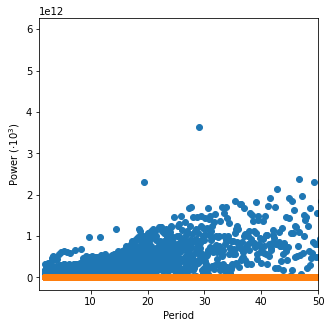

In [1073]:
ft_targets = fftpack.fft(reduced_df[target_cols], axis=0)
frequencies = fftpack.fftfreq(reduced_df[target_cols].shape[0],1)
periods = 1 / frequencies

periodicity_find=pd.DataFrame(abs(ft_targets) * 1e-3,columns=target_cols)
periodicity_find['periods']=periods

plt.figure(figsize=(5,5))


plt.plot(periodicity_find['periods'], periodicity_find[target_cols], 'o')
plt.xlim(1, 50)
plt.xlabel('Period')
plt.ylabel('Power ($\cdot10^3$)')

plt.show()

In [1074]:
periodicity_find[((periodicity_find['periods']>0) & (periodicity_find['periods']<50))].max()

WB_ny_gdp_mktp_cd       3.637061e+12
WB_ny_gdp_defl_kd_zg    1.655498e+02
periods                 4.987622e+01
dtype: float64

In [1075]:
periodicity_find[((periodicity_find['periods']>0) & (periodicity_find['periods']<50))].idxmax()

WB_ny_gdp_mktp_cd       528
WB_ny_gdp_defl_kd_zg    528
periods                 307
dtype: int64

In [1076]:
opt_period=np.rint(periodicity_find.loc[528,'periods'])

In [1077]:
#time constant t_r=0.35*period
t_r=opt_period*0.35

In [1238]:
window=np.rint(t_r/2).astype(np.int64)
print(window)

5


# First train the model for nontarget subjects (Global Data)

In [1239]:
#SCALE FEATURES 

In [1584]:
s=MinMaxScaler()
Xs=s.fit_transform(reduced_df.drop(columns=['SUBJECT','DATE']))
Ys=Xs

In [1585]:
X=[]
Y=[]

In [1586]:
subject_lists=reduced_df['SUBJECT'].unique().tolist()

subject_range_list=[]

for subject in subject_lists:
    range_subject=reduced_df.index[reduced_df['SUBJECT']==subject].tolist()
    
    if not subject in target_subjects:
        start=range_subject[0]
        end=range_subject[-1]
        
        for i in range(start+window,end+1):
            X.append(Xs[i-window:i,:])
            Y.append(Ys[i])
            subject_range_list.append(i)

In [1587]:
X, Y =np.array(X), np.array(Y)

In [1589]:
model = Sequential()

model.add(LSTM(units=32*Y.shape[1], activation='relu',input_shape=(X.shape[1], X.shape[2]), return_sequences=True ))


model.add(LSTM(units=8*Y.shape[1],return_sequences=False))

model.add(Dense(Y.shape[1]))
model.add(Activation("linear"))

model.compile(optimizer="adam",
              loss='mse',
              loss_weights=[1,0.001,0.001,0.01,0.00001,0.00001,0.00001,0.00001,0.00001]
             )

t0=time.time()

model.fit(X,Y, 
          epochs=30, 
          batch_size=128,  verbose=1, shuffle=False,
         )
        
t1=time.time()

Epoch 1/30
109/109 [==============================] - 9s 30ms/step - loss: 0.0426
Epoch 2/30
109/109 [==============================] - 3s 28ms/step - loss: 0.0136
Epoch 3/30
109/109 [==============================] - 3s 29ms/step - loss: 0.0094
Epoch 4/30
109/109 [==============================] - 3s 29ms/step - loss: 0.0094
Epoch 5/30
109/109 [==============================] - 3s 29ms/step - loss: 0.0086
Epoch 6/30
109/109 [==============================] - 3s 29ms/step - loss: 0.0072
Epoch 7/30
109/109 [==============================] - 3s 29ms/step - loss: 0.0057
Epoch 8/30
109/109 [==============================] - 3s 29ms/step - loss: 0.0056
Epoch 9/30
109/109 [==============================] - 3s 30ms/step - loss: 0.0053
Epoch 10/30
109/109 [==============================] - 3s 30ms/step - loss: 0.0057
Epoch 11/30
109/109 [==============================] - 3s 29ms/step - loss: 0.0054
Epoch 12/30
109/109 [==============================] - 3s 29ms/step - loss: 0.0048
Epoch 13/30
1

In [1590]:
print('Runtime: %.2f s' %(t1-t0))

Runtime: 111.43 s


<AxesSubplot:>

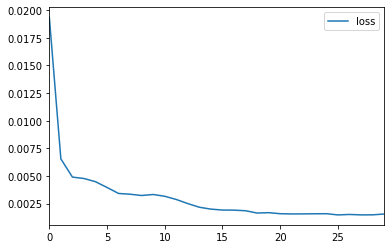

In [1591]:
# plot history
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

# Model Evaluation Global Data

In [1592]:
Y_pred=model.predict(X)
Y_pred=s.inverse_transform(Y_pred)
Y_pred=pd.DataFrame(Y_pred,index=subject_range_list, columns=reduced_df.drop(columns=['SUBJECT','DATE']).columns)
Y_pred['SUBJECT']=reduced_df.loc[subject_range_list]['SUBJECT']
Y_pred['DATE']=reduced_df.loc[subject_range_list]['DATE']
Y_pred=Y_pred[reduced_df.columns]
Y=reduced_df.loc[subject_range_list]

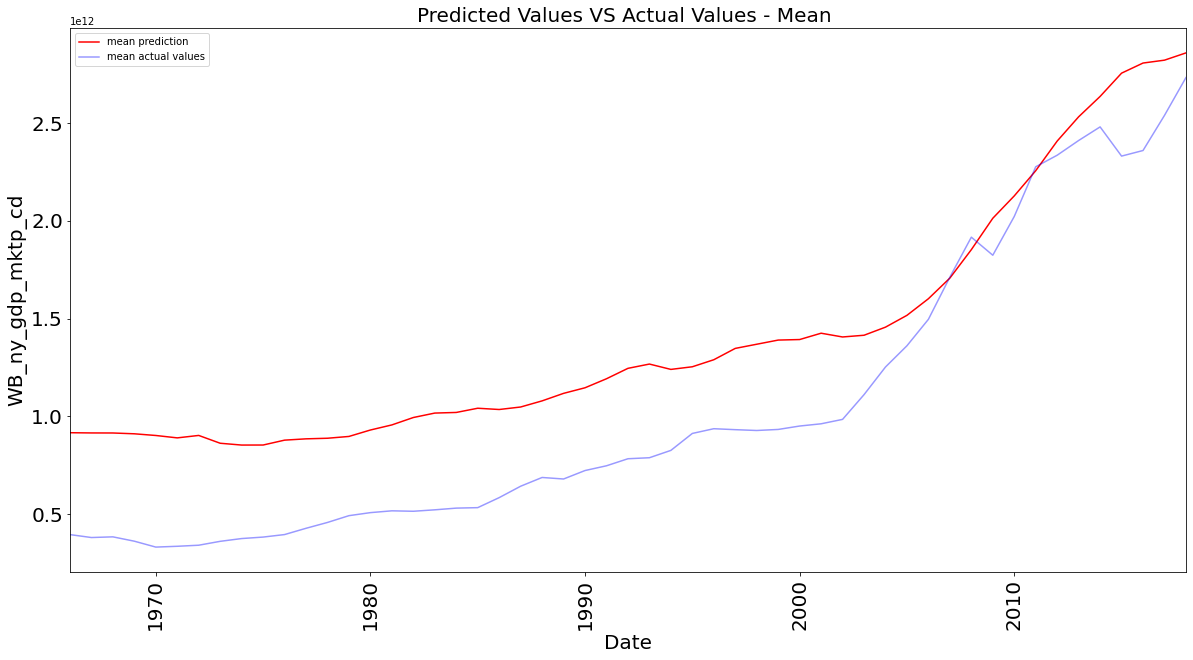

In [1593]:
plt.figure(figsize=(20,10))
Y_pred.groupby('DATE')[target_cols[0]].mean().plot(kind='line',label='mean prediction',color='red',alpha=1)
Y.groupby('DATE')[target_cols[0]].mean().plot(kind='line',label='mean actual values',color='blue',alpha=0.4)
plt.xticks(rotation=90,size=20)
plt.yticks(size=20)

plt.ylabel(target_cols[0],fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.title('Predicted Values VS Actual Values - Mean ',fontsize=20)
plt.legend()

In [1594]:
def RMSE(actual,prediction):
    rmse = np.sqrt(mean_squared_error(actual,prediction))
    return rmse

In [1595]:
print(RMSE(Y[target_cols[0]],Y_pred[target_cols[0]]))

838213444854.4957


In [1596]:
print(Y[target_cols[0]].mean())

1031744643339.0275


In [1597]:
print(RMSE(Y[target_cols[0]],Y_pred[target_cols[0]])/Y[target_cols[0]].mean())

0.8124233552032718


# LSTM for Target Subjects

In [1598]:
#create a train test split for given subject
def train_test_split(subject, percent=0.8):
    X_train=[]
    Y_train=[]
    X_test=[]
    Y_test=[]
    
    range_subject=reduced_df.index[reduced_df['SUBJECT']==subject].tolist()
    subject_test_range_list=[]
    
    start_train=range_subject[0]
    size=int((range_subject[-1]-range_subject[0])*percent)
    end_train=range_subject[size]
    
    for i in range(start_train+window,end_train+1):
        X_train.append(Xs[i-window:i,:])
        Y_train.append(Ys[i])        

    start_test=range_subject[size+1]
    end_test=range_subject[-1]
    
    for i in range(start_test,end_test+1):
        X_test.append(Xs[i-window:i,:])
        Y_test.append(Ys[i])
        subject_test_range_list.append(i) 
    
    X_train,Y_train,X_test,Y_test =np.array(X_train), np.array(Y_train),np.array(X_test), np.array(Y_test)
    
    return X_train, Y_train, X_test, Y_test, subject_test_range_list

Runtime: 2.23 s
644369529072.4093
Runtime: 2.18 s
6429950520005.101


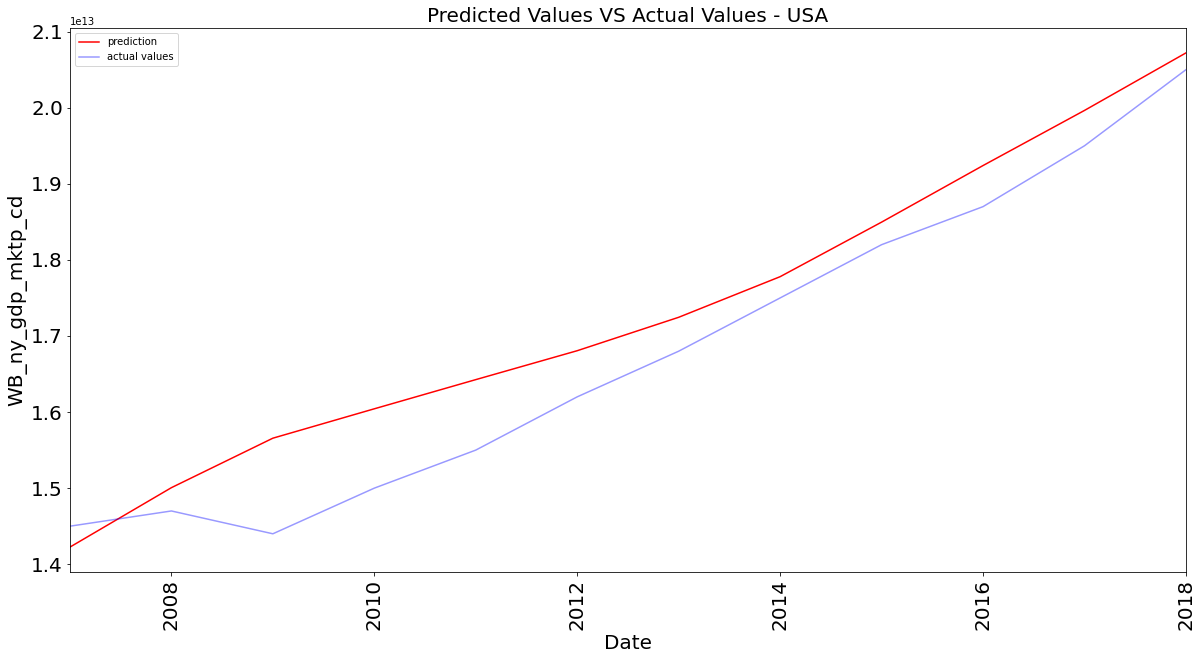

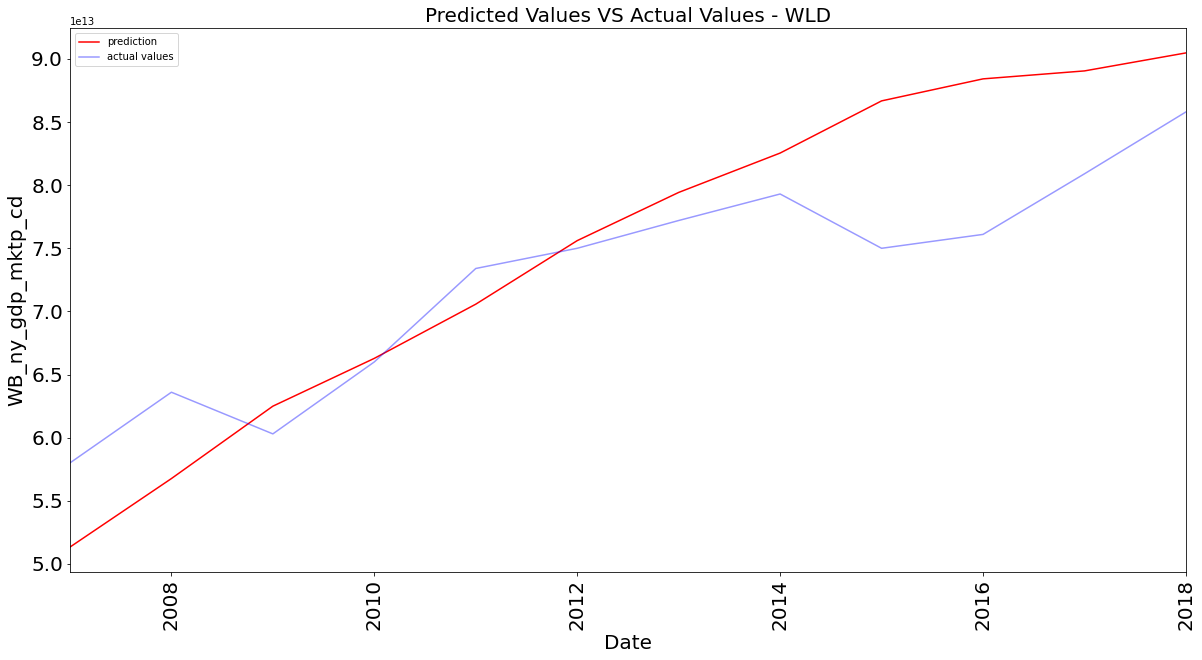

In [1601]:
# loop through target subjects
for i, subject in enumerate(target_subjects):
    X_train, Y_train, X_test, Y_test, subject_test_range_list = train_test_split(subject)
    
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    
    t0=time.time()
    model.fit(X_train,Y_train, 
              epochs=30, 
              batch_size=16,  verbose=0, shuffle=False,
              validation_data=(X_test, Y_test),
              callbacks=[early_stop])
    t1=time.time()
    print('Runtime: %.2f s' %(t1-t0))
    Y_test_pred=model.predict(X_test)
    Y_test_pred=s.inverse_transform(Y_test_pred)
    Y_test_pred=pd.DataFrame(Y_test_pred,index=subject_test_range_list, columns=reduced_df.drop(columns=['SUBJECT','DATE']).columns)
    Y_test_pred['SUBJECT']=reduced_df.loc[subject_test_range_list]['SUBJECT']
    Y_test_pred['DATE']=reduced_df.loc[subject_test_range_list]['DATE']
    Y=reduced_df.loc[subject_test_range_list]
    
    print(RMSE(Y[target_cols[0]],Y_test_pred[target_cols[0]]))
    
    plt.figure(figsize=(20,10))
    Y_test_pred.groupby('DATE')[target_cols[0]].mean().plot(kind='line',label='prediction',color='red',alpha=1)
    Y.groupby('DATE')[target_cols[0]].mean().plot(kind='line',label='actual values',color='blue',alpha=0.4)
    plt.xticks(rotation=90,size=20)
    plt.yticks(size=20)
    
    
    plt.ylabel(target_cols[0],fontsize=20)
    plt.xlabel('Date',fontsize=20)
    plt.title('Predicted Values VS Actual Values - %s' %(subject),fontsize=20)
    plt.legend()

# FORECAST

In [1602]:
#First fit model for test data then create a forcast for next periods

for i, subject in enumerate(target_subjects):
    X_train, Y_train, X_test, Y_test, subject_test_range_list = train_test_split(subject)
    
    t0=time.time()
    model.fit(X_test,Y_test, 
              epochs=60, 
              batch_size=16,  verbose=0, shuffle=False,
             ) 

In [ ]:
#Using predicted values to predict next step

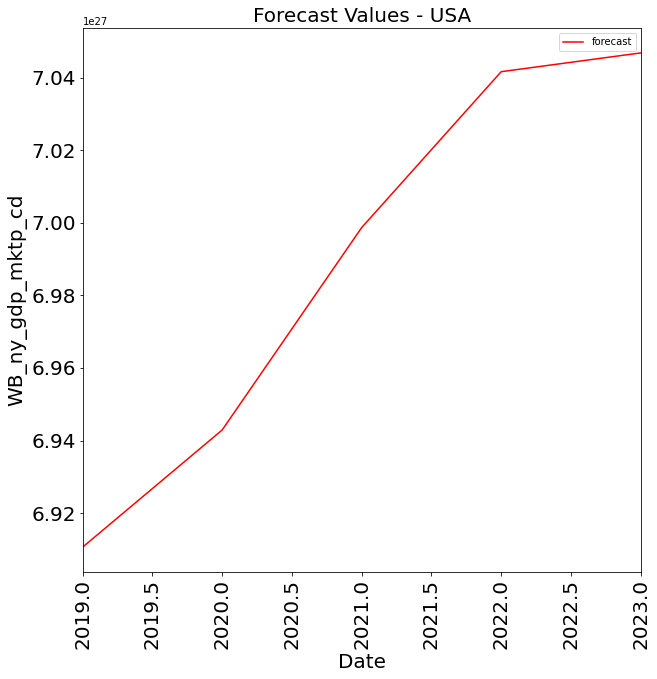

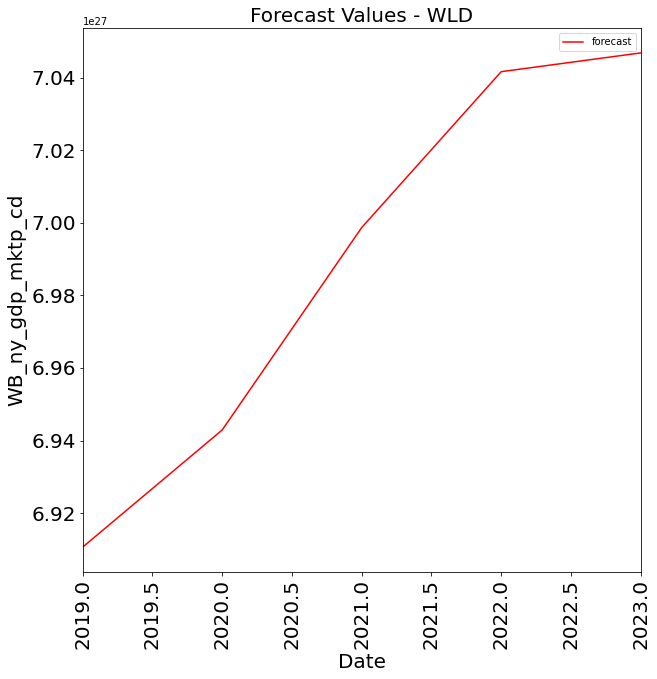

In [1648]:
for i, subject in enumerate(target_subjects):
    
    Yf=[]
    range_subject=reduced_df.index[reduced_df['SUBJECT']==subject].tolist()
    
    start=range_subject[-1]
    
    X=Xs[start+1-window:start+1,:].copy()
    for j in range(window,window+target_periods):
        Xin=X[j-window:j].reshape((1,window,-1))
        X=np.append(X,model.predict(Xin)).reshape((-1,9))
        Yf.append(X[-1])
    
    Yf=s.inverse_transform(Y)
    
    Yf=pd.DataFrame(Yf, columns=reduced_df.drop(columns=['SUBJECT','DATE']).columns)
    Yf['SUBJECT']=reduced_df.loc[start]['SUBJECT']
    Yf['DATE']=range(reduced_df.loc[start]['DATE']+1,reduced_df.loc[start]['DATE']+1+target_periods)
    
        
    plt.figure(figsize=(10,10))
    Yf.groupby('DATE')[target_cols[0]].mean().plot(kind='line',label='forecast',color='red',alpha=1)
    plt.xticks(rotation=90,size=20)
    plt.yticks(size=20)
    
    
    plt.ylabel(target_cols[0],fontsize=20)
    plt.xlabel('Date',fontsize=20)
    plt.title('Forecast Values - %s' %(subject),fontsize=20)
    plt.legend()  